In [18]:
import matplotlib.pyplot as plt
import os
import sys
import csv
import copy
import pandas as pd

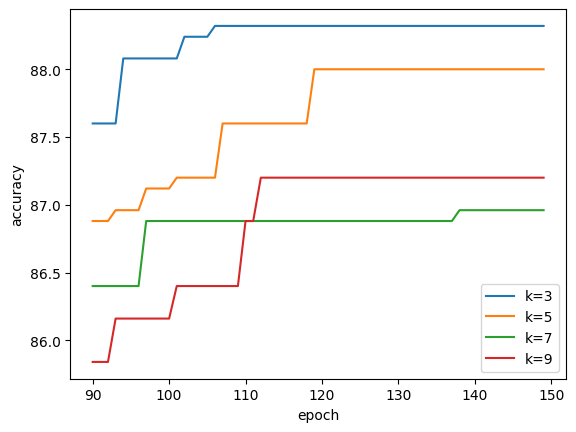

In [11]:
txt1 = "../checkpoint/mobilenet_k3_imagenet25_150-run1/acc.txt"
txt2 = "../checkpoint/mobilenet_k5_imagenet25_150-run2/acc.txt"
txt3 = "../checkpoint/mobilenet_k7_imagenet25_150-run3/acc.txt"
txt4 = "../checkpoint/mobilenet_k9_imagenet25_150-run4/acc.txt"


def get_acc(path):
    epoch_list = []
    acc_list = []

    with open(path, 'r') as file:
        for line in file:
            # 提取数字部分
            epoch_start = line.find('epoch:') + len('epoch:')
            epoch_end = line.find(',')
            epoch = int(line[epoch_start:epoch_end])
            
            best_acc_start = line.find('best_acc:') + len('best_acc:')
            best_acc = float(line[best_acc_start:])
            epoch_list.append(epoch)
            acc_list.append(best_acc)
    return epoch_list[-60:], acc_list[-60:]

epoch, acc = get_acc(txt1)
plt.plot(epoch,acc,label='k=3')
epoch, acc = get_acc(txt2)
plt.plot(epoch,acc,label='k=5')
epoch, acc = get_acc(txt3)
plt.plot(epoch,acc,label='k=7')
epoch, acc = get_acc(txt4)
plt.plot(epoch,acc,label='k=9')
plt.xlabel('epoch')
plt.ylabel("accuracy")
plt.legend()
plt.savefig('../fig/test5/mbv1_kernel_acc.png',dpi=300)

['/data/local/tmp/data/test5/test5_mbv1/cifar10/mbv1_k_1.ms', '0.000000000', '0.000000000', '6.458600000\n']
['/data/local/tmp/data/test5/test5_mbv1/cifar10/mbv1_k_3.ms', '0.000000000', '0.000000000', '5.153266667\n']
['/data/local/tmp/data/test5/test5_mbv1/cifar10/mbv1_k_5.ms', '0.000000000', '0.000000000', '5.099700000\n']
['/data/local/tmp/data/test5/test5_mbv1/cifar10/mbv1_k_7.ms', '0.000000000', '0.000000000', '5.094833333\n']
['/data/local/tmp/data/test5/test5_mbv1/cifar10/mbv1_k_9.ms', '0.000000000', '0.000000000', '5.138233333\n']
['/data/local/tmp/data/test5/test5_mbv1/cifar10/mbv1_k_11.ms', '0.000000000', '0.000000000', '5.132533333\n']
['/data/local/tmp/data/test5/test5_mbv1/cifar10/mbv1_k_13.ms', '0.000000000', '0.000000000', '5.143333333\n']
['/data/local/tmp/data/test5/test5_mbv1/cifar10/mbv1_k_15.ms', '0.000000000', '0.000000000', '5.212700000\n']
['/data/local/tmp/data/test5/test5_mbv1/cifar10/mbv1_k_17.ms', '0.000000000', '0.000000000', '5.148233333\n']
['/data/local/t

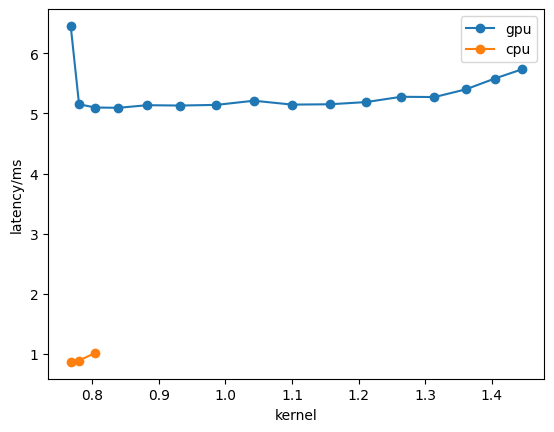

In [50]:
def get_col(data,label):
    x = data[label]
    y = [i for i in x]
    return y

def get_latency(device,dataset):

    csv_path = "../data/test5/test5_mbv1/{}/test5_mbv1_{}.csv".format(dataset,dataset)
    latency_path = "../data/test5/test5_mbv1/{}/data/{}.txt".format(dataset,device)
    write_path = "../data/test5/test5_mbv1/{}/latency/{}.csv".format(dataset,device)
    txt = open(latency_path, 'r')
    latency = txt.readlines()
    info, data = latency[:3], latency[3:]
    latency_dict = {}
    for i in data:
        tmp = i.split(" ")
        print(tmp)
        (filepath, filename) = os.path.split(tmp[0])
        (name, suffix) = os.path.splitext(filename)
        latency_dict[name] = [float(tmp[1]),float(tmp[2]),float(tmp[3])]
    read_file = open(csv_path,"r", encoding='utf-8')
    reader = csv.reader(read_file)
    title = ['op','index','H', 'in_c', 'out_c', 'stride', 'kernel_size', 'FLOPs', 'Params', 'MACs','load_time','first_time','avg_time']
    writer = csv.writer(open(write_path, 'w'))
    
    writer.writerow(title)
    for row in reader:
        if row[0] == "op":
            continue
        name = "{}_{}_{}".format("mbv1", 'k',row[6])
        if name in latency_dict.keys():
            load_time = latency_dict[name][0]
            first_time = latency_dict[name][1]
            avg_time = latency_dict[name][2]
            tmp = copy.deepcopy(row)
            # tmp.pop(2)
            # tmp.pop(0)
            tmp.append(load_time)
            tmp.append(first_time)
            tmp.append(avg_time)
            writer.writerow(tmp)

def show(device,dataset):
    write_path = "../data/test5/test5_mbv1/{}/latency/{}.csv".format(dataset,device)
    read_file = open(write_path,"r", encoding='utf-8')
    data = pd.read_csv(read_file)
    first_time = get_col(data, 'first_time')
    # print(first_time)
    load_time = get_col(data, 'load_time')
    avg_time = get_col(data, 'avg_time')
    FLOPs = get_col(data, 'FLOPs')
    params = get_col(data, 'Params')
    total_size = get_col(data, 'MACs')
    channel = get_col(data, 'in_c')
    kernel = get_col(data, 'kernel_size')
    intensity = []
    Flops = []
    bandwidth = []
    comp = []
    for i in range(len(first_time)):
        intensity.append(float(FLOPs[i])/float(total_size[i]))
        Flops.append(float(FLOPs[i])/float(avg_time[i]))
        # bandwidth.append(float(total_size[i])/float(load_time[i]))
        comp.append(float(first_time[i])/avg_time[i])
    total_size = [float(i)/1024 /1024 for i in total_size]
    plt.xlabel("intensity")
    plt.ylabel("FLOPS")
    # plt.xscale("log")
    # z1 = np.polyfit(intensity, Flops, 3)
    # p1 = np.poly1d(z1)
    # # plt.ylim(0,3)
    # yval = p1(intensity)
    # plt.plot(intensity, yval, 'r',label='polyfit values')
    # plt.scatter(kernel,intensity)
    # plt.show()
    # plt.scatter(flops,intensity)
    # plt.show()
    # plt.savefig("../fig/test5/1.png",dpi=300)
    # plt.legend()
    return intensity,avg_time

device = 'redmik50'
type = 'intensity'
dataset="cifar10"
get_latency('{}_gpu'.format(device),dataset)
a,b = show('{}_gpu'.format(device),dataset)
c,d = show('{}_bigcore'.format(device),dataset)
plt.plot(a,b,label='gpu',marker='o')
plt.plot(c,d,label='cpu',marker='o')
plt.xlabel('kernel')
plt.ylabel('latency/ms')
plt.legend()
plt.savefig("../fig/test5/mbv1_{}_{}_{}.png".format(device,type,dataset),dpi=300)